<a href="https://colab.research.google.com/github/sebastianmunozvasq/Portfolio-SMV/blob/Boundary-value-problems/Modeling_of_an_Industrial_Radiator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modeling of an Industrial Radiator



### Model Description

Water radiators are part of the heating system equipment that helps maintain a comfortable temperature in a space when it is cold. A radiator can be modeled as a rectangular slot, with length $L$, height $B$, and depth $W$, through which hot water flows. The fluid heats the metal of the fins, which in turn heats the surrounding air through natural convection and radiation.

The fluid flows from right to left in the $x$ direction. As a first approximation, a directional flow with a piston-like flow profile will be assumed. This flow profile is characterized by the fact that if a control volume of the fluid were taken, it would move like a "piston". Under this assumption, the velocity is constant throughout the space and equal to $v_0$. That is, velocity gradients near the pipe walls are neglected.

Additionally, the system is in a steady state, so there are no temperature variations with respect to time.

* It will be assumed that thermophysical properties are constant, and that the thermal resistance of the walls is negligible. For the calculation of thermophysical properties, it is suggested to use the average pressure of the water in the slot, which is $\bar{P} = 200 kPa$.
* It will also be assumed that the dimensions of the cross-sectional area of the slot are much smaller than its length. That is, $B \ll L$ and $W \ll L$. This implies that temperature variations in the $z$ and $y$ directions are negligible, and only variations in the direction parallel to the flow will be considered.


### Governing Equation

The ordinary differential equation (ODE) that describes the temperature profile of the pipe in a steady state, subject to heat losses due to natural convection and radiation, is:

\begin{equation}
\text{ODE}: \alpha\frac{d^2T}{dx^2} = v_{0}\frac{dT}{dx} +  \frac{2 h}{\rho c_p B}(T-T_{aire}) + \frac{2 \sigma \varepsilon}{\rho c_p B}(T^4-T_{aire}^4)
\end{equation}

This is a nonlinear differential equation due to the presence of $T^4$ in the radiant cooling term.


### Boundary Conditions:

For this model, it will be assumed that the temperature at the entrance of the slot is known. This is reasonable since most radiators or domestic boilers have a control system with a temperature sensor at the entrance. Therefore, at $x=0$, the following non-homogeneous Dirichlet boundary condition is applied:

\begin{equation}
\text{BC1}:  T|_{x=0} = T_{in}
\end{equation}

At the radiator's exit, it will be assumed that the forced convection "continues" into the rest of the system without obstructions. This translates to a *through-flow* condition, which, in this particular case, takes the form of a homogeneous Neumann boundary condition:

$$\text{BC2}:\frac{d T}{d x}|_{x=L} = 0$$


#### Boundary Value Problem
The ODE along with the boundary conditions CB1 and CB2 constitute a nonlinear boundary value problem. In this practical exercise:

1. You will need to find the temperature profile using the fixed-point iteration method.
2. Next, you will calculate engineering quantities of interest, such as the average temperature and the heat flux at different parts of the bar.
3. Finally, you will compare the contributions of convection and conduction transport.



#### PropsSI


In [ ]:
# Import libraries for plotting
import matplotlib.pyplot as plt

# Import libraries for numerical computation
import numpy as np

# Install CoolProp
!pip install CoolProp

# Import thermophysical properties
from CoolProp.CoolProp import PropsSI


#### Definition of Variables

The following code cell defines the values of the relevant geometric, heat transfer, and thermodynamic parameters needed to solve the problem of interest.


In [ ]:
L = 50                                                      # Length of the slot [m]
B = 0.01                                                    # Width of the slot [m]
W = 1                                                       # Height of the slot [m]
v_0 = 1e-1                                                  # Fluid velocity [m s^-1]
h = 30                                                      # Natural convection heat transfer coefficient [W m^-2 K^-1]
em = 0.9                                                    # Material emissivity
sigma = 5.670374419e-8                                      # Stefan-Boltzmann constant [W m^-2 K^-4]
T_air = 273 + 18                                           # Air temperature [K]
T_in = 273 + 75                                            # Inlet temperature [K]
P = 200e3                                                   # Average pressure of water in the slot [Pa]

# The following properties are obtained using the PropsSI function
# from the CoolProp module

c_p = PropsSI('C', 'T', T_in, 'P', P, 'Water')               # Specific heat capacity at constant pressure [J kg^-1 K^-1]
rho = PropsSI('D', 'T', T_in, 'P', P, 'Water')               # Fluid density [kg m^-3]
k = PropsSI('L', 'T', T_in, 'P', P, 'Water')                 # Thermal conductivity [W m^-1 K^-1]
alpha = k / (rho * c_p)                                      # Thermal diffusivity [m^2 s^-1]

# The following code prints the values obtained from CoolProp.
# Units were defined above.
w = [print(f"{name} = {value:.3e}") for name, value in [('Specific heat capacity', c_p), ('Density', rho), ('Thermal conductivity', k), ('Thermal diffusivity', alpha)]]



Specific heat capacity = 4.193e+03
Density = 9.750e+02
Thermal conductivity = 6.635e-01
Thermal diffusivity = 1.623e-07


### Part 1: Discretization of the Boundary Value Problem


#### Discretization
1. Write the discretized equation valid for the interior nodes of the domain.
2. Factor the resulting expression to find the terms that multiply $T_{i-1}$, $T_i$, and $T_{i+1}$. These terms should be on the left side of the equation.
3. Ensure that on the right side, you have the components of the vector $\mathbf{b}$ that do not depend on the temperatures of the nodes, and the nonlinear function $\mathbf{f}(T_i)$.
4. Discretize the boundary conditions. For the second boundary condition, use second-order backward finite differences.


### Part 2: Numerical Implementation

#### 2.1 Generating Matrices and Vectors
In the following cell, you will generate the base matrices and vectors to apply the algorithm.

* First, define the one-dimensional grid in the direction $x$. Use 1001 nodes.
* Then, construct the coefficient matrix A.
* Finally, construct the right-hand side vector b.

In [ ]:
# Number of nodes
x_range = (0.0, L)
N = 101

# Spacing
dx = L/(N-1)

# Grid
x_grid = np.linspace(0.0, L, N)

# Matrix initialization
# Natural convection parameter
k1 = 2 * h / (B * rho * c_p)

# Radiation parameter
k2 = 2 * em * sigma / (B * rho * c_p)

# Conduction parameter
r1 = alpha / (dx**2)

# Convection parameter
r2 = v_0 / (2 * dx)

A = np.zeros([N, N])
# First row of the matrix associated with node i = 0
A[0][0] = 1

# For loop for intermediate rows from i = 1 to Nx-1
for i in range(1, N-1):
    # Constant multiplying T[i-1]
    A[i][i-1] = r1 + r2

    # Constant multiplying T[i]
    A[i][i] = -2*r1 - k1

    # Constant multiplying T[i+1]
    A[i][i+1] = r1 - r2

# Last row of the matrix associated with node i = N
A[-1][-3] = 1
A[-1][-2] = -4
A[-1][-1] = 3
# Note that the temperature value at this node will directly depend
# on the values of the two previous nodes

# Construct the vector b
b = np.zeros(N)

# First element of the vector b
b[0] = T_in

# Intermediate elements of the vector b
for i in range(1, N-1):
    b[i] = - k1 * T_air

# Last element
b[-1] = 0
print(b)


[348.          -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710721  -0.42710721  -0.42710721  -0.42710721  -0.42710721
  -0.42710

#### 2.2 Fixed-Point Iteration Implementation
In this section, you will implement the fixed-point iteration. Note that the right-hand side vector f will be initialized and updated in the next cell. Since this function is nonlinear, its value will vary with each iteration.


In [ ]:
# Initialize zero vector for the right-hand side vector f
f = np.zeros(N)

# Initialize temperature vector

# Find an initial solution consisting of the
# temperature profile without considering the function f
Tconv = np.linalg.solve(A, b)
T0 = Tconv

# Initialize a counter to 0
j = 0

# Define a maximum number of iterations
jmax = 1000

# Initialize an error. Consider a value larger than the tolerance
err = 1

# Define tolerance
tol = 1e-6

# Print error
print('j error')

# Iteration
# While loop
while err > tol and j < jmax:
    # Construct right-hand side vector for interior nodes
    for i in range(1, N-1):
        f[i] = k2 * (T0[i]**4 - T_air**4)

    # Solve matrix system
    tmp = b + f
    T = np.linalg.solve(A, tmp)

    # Calculate new error
    err = np.linalg.norm(T - T0)
    print(j, err)

    # Increase iteration counter
    j = j + 1

    # Update old temperature to the new temperature calculated in this iteration
    T0 = T


j error
0 30.114157484022257
1 1.9593105525876657
2 0.09493885356352398
3 0.0037495396714459484
4 0.00013516898193375747
5 5.574080098495184e-06
6 3.0973109983351544e-07


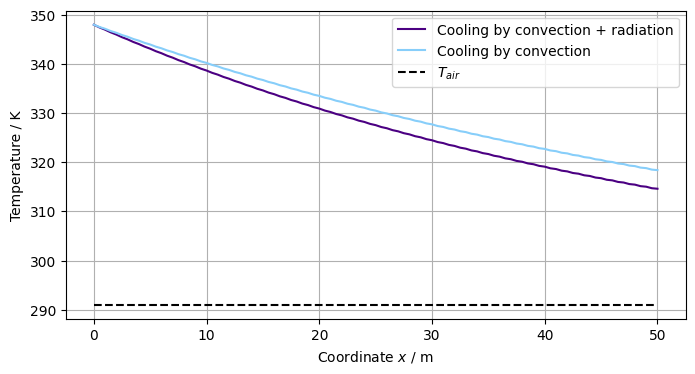

In [ ]:
# Optional: plot the temperature profile
fig = plt.subplots(figsize=[8, 4])

plt.plot(x_grid, T, color='indigo', label='Cooling by convection + radiation')
plt.plot(x_grid, Tconv, 'lightskyblue', label='Cooling by convection')
plt.plot(x_grid, x_grid * 0 + T_air, 'k--', label='$T_{air}$')

plt.grid()
plt.legend(fontsize=10)
plt.tick_params(labelsize=10)
plt.xlabel('Coordinate $x$ / m')
plt.ylabel('Temperature / K')

plt.show()


What is the outlet temperature of the radiator water?

In [ ]:
# Write the code to solve the question
print(f"Radiator water outlet temperature: {T[-1]:.2f} K")


Radiator water outlet temperature: 314.61 K


#### Calculate the average temperature of the water in the radiator.



In [ ]:
# Resolution code
T_average = np.trapz(T,x_grid)/L

print(f"Average radiator water temperature: {T_average:.2f} K")

Average radiator water temperature: 328.76 K


#### Calculate the heat flux removed by natural convection.


In [ ]:
# Calculation of the heat flux removed by natural convection

# Volume of the fluid inside the slit
fluid_volume = L * B * W # m^3

# Natural convection term (in W/m3)
Q_conv_term = 2 * h * (T - T_air) / B

# Average natural convection term along the slit
Q_conv_term_average = np.mean(Q_conv_term)

# Heat flux removed by natural convection (in W)
Q_conv = Q_conv_term_average * fluid_volume

# Conversion to kilowatts
Q_conv_kW = Q_conv / 1000 # kW

# Result
print(f"Heat flux removed by natural convection: {Q_conv_kW:.1f} kW")

Heat flux removed by natural convection: 113.4 kW


#### Calculate the ratio of the heat flux removed by radiation to the total heat flux.


In [ ]:
# Calculation of the heat flux removed by radiation

# Radiation term (in W/m3)
Q_rad_term = 2 * em * sigma * (T**4 - T_air**4) / B

# Average radiation term along the slit
Q_rad_term_average = np.mean(Q_rad_term)

# Radiated heat flux removed by radiation (in W)
Q_rad = Q_rad_term_average * fluid_volume

# Conversion to kilowatts
Q_rad_kW = Q_rad / 1000 # kW

# Total heat flux removed (convection + radiation)
Q_total = Q_conv + Q_rad

# Ratio of radiative heat flux removed to total heat flux
reason_Q_rad_Q_total = Q_rad / Q_total

# Results
print(f"Heat flux removed by radiation: {Q_rad_kW:.1f} kW")
print(f"Ratio of heat flux removed by radiation to total heat flux: {reason_Q_rad_Q_total:.3f}")

Heat flux removed by radiation: 23.4 kW
Ratio of heat flux removed by radiation to total heat flux: 0.171
